## TODO

- Las columnas con NaN no se pueden convertir a enteros, se pueden convertir a Int64Dtype() pero esto no lo acepta la maquina de LGBoost, ¿que hacer ahí? en los notebooks visto pasan primero la columna a string y después utilizan label encoder, lo que sería como inputar los NaN a una nueva variable

In [1]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import pandas as pd

import sys
sys.path.append('..')
from utils import plot_counts_and_proportion, read_train_transaction, get_categorical_from_df

In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


def get_trues(Ser):
    return Ser[Ser].index

def encode_object_cols(object_cols, X_train, X_test=None ):
    les = []
    for col in object_cols:
        # Enconde variables
        le = LabelEncoder()
        le.fit(list(X_train[col].astype(str).values) + list(X_test[col].astype(str).values))
        X_train.loc[: ,col] = le.transform(list(X_train[col].astype(str).values))
        X_test.loc[: ,col] = le.transform(list(X_test[col].astype(str).values))
        
        # notnull = X.loc[:, col].notnull()
        # X.loc[notnull, col] = le.fit_transform(X.loc[notnull, col])
        
        # Change type
        # X.loc[:, col] = X[col].astype(pd.Int64Dtype()) # Permite NaNs
        les.append(le)
    return X_train, X_test, les

In [3]:
X, y = read_train_transaction(nrows=5000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [4]:
X_train[get_trues(X_train.dtypes == 'O')].head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,
2991154,W,visa,debit,aol.com,NaN,T,T,T,NaN,NaN,F,T,T,T
2991820,W,visa,credit,yahoo.com,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN
2988202,W,mastercard,debit,mail.com,NaN,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN
2990759,C,visa,credit,hotmail.com,hotmail.com,NaN,NaN,NaN,M0,NaN,NaN,NaN,NaN,NaN
2987622,W,visa,debit,gmail.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN


In [5]:
X_train, X_test, les_train = encode_object_cols(get_trues(X_train.dtypes == 'O'), X_train, X_test )

/home/pablo-ubuntu/anaconda3/envs/lgd/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
X_train[get_trues(X.dtypes == 'O')].head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,
2991154,4,3,1,1,18,0,1,1,3,2,0,1,1,1
2991820,4,3,0,41,18,1,2,2,3,2,0,2,2,2
2988202,4,2,1,23,18,1,2,2,3,2,1,2,2,2
2990759,0,3,0,16,9,1,2,2,0,2,2,2,2,2
2987622,4,3,1,14,18,1,2,2,0,1,0,2,2,2


In [7]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

#basic parameter:
parameters = {
    'application': 'binary',
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'boosting_type': 'gbdt',
    'boosting': 'gbdt',
    'categorical_feature': get_categorical_from_df(X_train)[0],
    'learning_rate': 0.05,
    'metric': 'auc',
    'min_data': 50,
    'max_depth': 10,
    'is_unbalance': 'true',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'objective': 'binary',
    'sub_feature': .5,
    'verbose': 0
}

In [8]:
clf = lgb.train(parameters,
               train_data,
               valid_sets=test_data,
               num_boost_round=50000,
               early_stopping_rounds=10000)

# clf = lgb.train(parameters, train_data, 100)

#Prediction
# y_pred = clf.predict(X_test)

/home/pablo-ubuntu/anaconda3/envs/lgd/lib/python3.7/site-packages/lightgbm/basic.py:794: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's auc: 0.668347
Training until validation scores don't improve for 10000 rounds
[2]	valid_0's auc: 0.666762
[3]	valid_0's auc: 0.66168
[4]	valid_0's auc: 0.637281
[5]	valid_0's auc: 0.643757
[6]	valid_0's auc: 0.641694
[7]	valid_0's auc: 0.643839
[8]	valid_0's auc: 0.642309
[9]	valid_0's auc: 0.637664
[10]	valid_0's auc: 0.623005
[11]	valid_0's auc: 0.623333
[12]	valid_0's auc: 0.624973
[13]	valid_0's auc: 0.624098
[14]	valid_0's auc: 0.620806
[15]	valid_0's auc: 0.620068
[16]	valid_0's auc: 0.61515
[17]	valid_0's auc: 0.613128
[18]	valid_0's auc: 0.612036
[19]	valid_0's auc: 0.612883
[20]	valid_0's auc: 0.609658
[21]	valid_0's auc: 0.688593
[22]	valid_0's auc: 0.686134
[23]	valid_0's auc: 0.689932
[24]	valid_0's auc: 0.690178
[25]	valid_0's auc: 0.699822
[26]	valid_0's auc: 0.704549
[27]	valid_0's auc: 0.70515
[28]	valid_0's auc: 0.707964
[29]	valid_0's auc: 0.713593
[30]	valid_0's auc: 0.717609
[31]	valid_0's auc: 0.724167
[32]	valid_0's auc: 0.726052
[33]	valid_0's auc: 

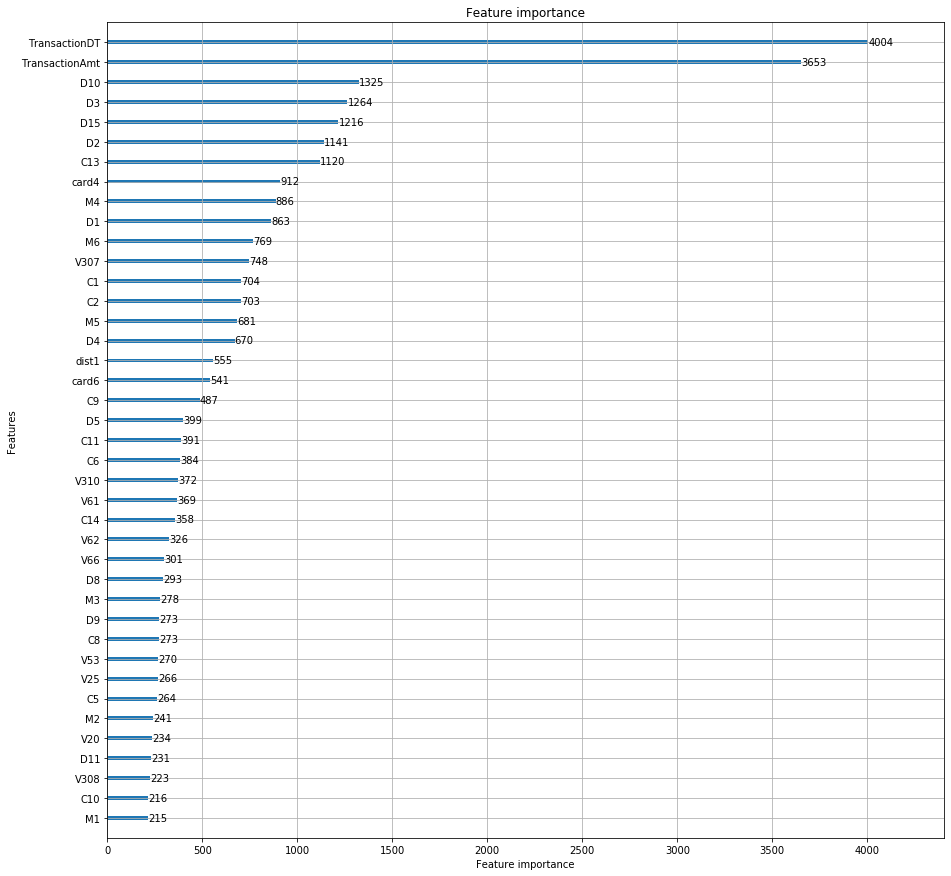

In [9]:
ax = lgb.plot_importance(clf, max_num_features=40, figsize=(15,15))
plt.show()

In [11]:
y_pred_proba = clf.predict(X_test)

In [12]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
y_pred_bin = y_pred_proba > .5
cm = confusion_matrix(y_test, y_pred_bin)

In [13]:
cm

array([[1220,    0],
       [  21,    9]])

In [14]:
roc_auc_score(y_test, y_pred_proba)

0.8864480874316939

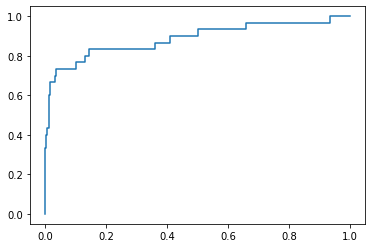

In [16]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_rf, tpr_rf, label='RF')